# VGGish CNN classifier with VCAE for synthetic data generation

## Loading and formatting the data

In [1]:
!pip install torchvggish

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 29.1 MB/s eta 0:00:00
  Created wheel for torchvggish: filename=torchvggish-0.2-py3-none-any.whl size=10592 sha256=d8bcdcd50c591208ad33a5d8bda76552cc2ccfdc522e210b4aed424ea19f7ce9
  Stored in directory: /root/.cache/pip/wheels/0c/b6/62/5c9bd6c165455610ef9b53638fa065b488ece3e06571b4ff0d
Successfully built torchvggish


In [2]:
# Import packages
import numpy as np
import pandas as pd
import os
import torch
import torchaudio
import torchaudio.transforms as transforms
from torch.utils.data import Dataset
import IPython.display as ipd
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Subset

In [3]:
# This will prompt you to give Colab access to your Drive files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Read in audio files

# Respiratory_Sound_Database/audio_and_txt_files/ specifies the folder containing .wav and .txt files on my Drive
dataset_path = "/content/drive/MyDrive/Respiratory_Sound_Database/audio_and_txt_files/" # tweaked this file path to run on my laptop, pls change if needed - lucy

audio_files = [f for f in os.listdir(dataset_path) if f.endswith(".wav")]
len(audio_files)

920

In [5]:
# Read in diagnosis information

diagnosis_df = pd.read_csv("/content/drive/MyDrive/Respiratory_Sound_Database/patient_diagnosis.csv", header=None, names=['pt_id', 'diag'])
diagnosis_df.pt_id = diagnosis_df.pt_id.astype(str)
len(diagnosis_df)

126

In [6]:
# Map audio files to diagnoses

# Function to extract patient ID from filename
def get_pt_id(filename):
    return filename.split('_')[0]

# Create a list to store (filepath, waveform, sample_rate, diagnosis)
dat = []

for audio_file in audio_files:
    patient_id = get_pt_id(audio_file)  # Extract patient ID
    diagnosis = diagnosis_df.loc[diagnosis_df["pt_id"] == patient_id, "diag"].values

    if len(diagnosis) > 0:
        diagnosis = diagnosis[0]
    else:
        diagnosis = "Unknown"

    audio_path = os.path.join(dataset_path, audio_file)  # Full path
    #waveform, sample_rate = torchaudio.load(audio_path)  # Load audio
    waveform, sample_rate = torchaudio.load(dataset_path + audio_file)

    dat.append((audio_path, waveform, sample_rate, diagnosis))

# Check first few entries
for i in range(3):
    print(dat[i])


('/content/drive/MyDrive/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Tc_mc_AKGC417L.wav', tensor([[0.0000, 0.0000, 0.0000,  ..., 0.2042, 0.2050, 0.2051]]), 44100, 'COPD')
('/content/drive/MyDrive/Respiratory_Sound_Database/audio_and_txt_files/160_1b4_Ar_mc_AKGC417L.wav', tensor([[0.0000, 0.0000, 0.0000,  ..., 0.1118, 0.1131, 0.1136]]), 44100, 'COPD')
('/content/drive/MyDrive/Respiratory_Sound_Database/audio_and_txt_files/160_1b3_Ar_mc_AKGC417L.wav', tensor([[0.0000, 0.0000, 0.0000,  ..., 0.5175, 0.5198, 0.5223]]), 44100, 'COPD')


In [7]:
len(dat)

920

## Data preprocessing

In [8]:
# Standardizing the sample rate to 16 kHz and resolving the mix of mono and multi-channel audio
target_sample_rate = 16000

dat = []

for audio_file in audio_files:
    patient_id = get_pt_id(audio_file)
    diagnosis = diagnosis_df.loc[diagnosis_df["pt_id"] == patient_id, "diag"].values

    diagnosis = diagnosis[0] if len(diagnosis) > 0 else "Unknown"

    audio_path = os.path.join(dataset_path, audio_file)
    waveform, sample_rate = torchaudio.load(audio_path)

    # check if the sample rate is 16kHz, resample if it is not
    if sample_rate != target_sample_rate:
        resampler = transforms.Resample(orig_freq=sample_rate, new_freq=target_sample_rate)
        waveform = resampler(waveform)
        sample_rate = target_sample_rate

    dat.append((audio_path, waveform, sample_rate, diagnosis))

    # check if mono channel, otherwise change to mono channel

    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

# loop through the list to verify standardization
check_16 = all(sample_rate == 16000 for _, _, sample_rate, _ in dat)

if check_16:
    print("all audio files are 16 kHz.")
else:
    print("not all audio files are 16 kHz.")
    # Optionally print which ones
    #for i, (path, _, sample_rate, _) in enumerate(dat):
        #if sample_rate != 16000:
            #print(f"File {i}: {path} has sample rate {sample_rate}")

# check that all waveforms have successfully been converted the mono channel
all_mono = all(waveform.shape[0] == 1 for _, waveform, _, _ in dat)
print("all waveforms are mono.") if all_mono else print("not all waveforms are mono.")


all audio files are 16 kHz.
all waveforms are mono.


In [9]:
# Normalize amplitude

def normalize_waveform(waveform):
    peak = waveform.abs().max()
    if peak > 0:
        waveform = waveform / peak
    return waveform

for i in range(len(dat)):
    path, waveform, sr, diag = dat[i]
    waveform = normalize_waveform(waveform)
    dat[i] = (path, waveform, sr, diag)

all_normalized = all(torch.isclose(waveform.abs().max(), torch.tensor(1.0), atol=1e-3)
                     or waveform.abs().max() == 0
                     for _, waveform, _, _ in dat)

print("all waveforms are amplitude-normalized.") if all_normalized else print("NOT all waveforms are normalized.")


all waveforms are amplitude-normalized.


In [10]:
# Standardizing duration with a sliding window approach

window_length = 48000  # size of each window = 3 second (account for full breathing cycle)
stride = 24000  # 50% overlap between consecutive windows

windowed_dat = []  # storage for window_tensor (1 sec chunk of waveform), diagnosis (label), original_path)

# loop through each preprocessed audio entry
for path, waveform, sr, diag in dat:
    total_samples = waveform.size(1)

    # skip files that are shorter than a single window
    if total_samples < window_length:
        continue

    # loop through window using specified sliding window
    for start in range(0, total_samples - window_length + 1, stride):
        end = start + window_length
        window = waveform[:, start:end]
        windowed_dat.append((window, diag, path)) # append window + meta data to windowed_dat

print(f"Total number of windows: {len(windowed_dat)}")

Total number of windows: 11944


In [44]:
# Convert to mel spectrogram form

# Define a Mel Spectrogram transformation
mel_spectrogram = transforms.MelSpectrogram(sample_rate=16000, n_mels=64)

# Function to normalize a single spectrogram
def normalize_spec(spec):
    return (spec - spec.mean()) / (spec.std() + 1e-6)

# List to store results
mel_windowed_dat = []

# Loop through all windowed samples
for window_tensor, diag, path in windowed_dat:
    mel_spec = mel_spectrogram(window_tensor) + 1e-6  # avoid log(0)
    log_mel_spec = torch.log(mel_spec)
    log_mel_spec = normalize_spec(log_mel_spec)
    mel_windowed_dat.append((log_mel_spec, diag, path)) # append results

print(f"Total Mel Spectrogram windows: {len(mel_windowed_dat)}")

Total Mel Spectrogram windows: 11944


## VCAE for generating minority class synthetic data

In [45]:
from collections import Counter
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
import random
from sklearn.utils.class_weight import compute_class_weight

# Remove Asthma and LRTI (too few samples)
filtered_mel_data = [(spec, diag, path) for spec, diag, path in mel_windowed_dat if diag not in ["Asthma", "LRTI"]]

# Separate by class
copd_samples = [item for item in filtered_mel_data if item[1] == "COPD"]
other_samples = [item for item in filtered_mel_data if item[1] != "COPD"]

# Randomly downsample COPD to 2000 samples
copd_downsampled = random.sample(copd_samples, 2000)

# New filtered dataset
filtered_mel_data = copd_downsampled + other_samples

# Resize all real mel spectrograms to [1, 64, 96]
resized_filtered_mel_data = []
for spec, diag, path in filtered_mel_data:
    if spec.dim() == 3:
        spec = spec.unsqueeze(0)  # [1, 1, 64, T]
    resized_spec = F.interpolate(spec, size=(64, 96), mode='bilinear')  # [1, 1, 64, 96]
    resized_filtered_mel_data.append((resized_spec.squeeze(0), diag, path))

filtered_mel_data = resized_filtered_mel_data  # overwrite original list

print(f"Filtered dataset size: {len(filtered_mel_data)}")

# Encode labels
filtered_labels = [diag for _, diag, _ in filtered_mel_data]
label_encoder = LabelEncoder()
filtered_encoded_labels = label_encoder.fit_transform(filtered_labels)

# Count class frequencies
diagnosis_counts = Counter(filtered_labels)
print("Diagnosis counts after filtering:", diagnosis_counts)

# Define minority classes: any class not equal to "COPD"
class_freq = pd.Series(diagnosis_counts)
minority_classes = [c for c in class_freq.index if c != "COPD"]
print("Minority classes to augment:", minority_classes)

# Define variational convolutional autoencoder (VCAE)
class VCAE(nn.Module):
  """
  1) encodes input spectrogram into latent space
  2) reparamaterizes (adds noise to learn robust features)
  3) decodes latent vector into new spectrogram
  """
    def __init__(self, latent_dim=32):
        super(VCAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(32 * 16 * 24, latent_dim)
        self.fc_logvar = nn.Linear(32 * 16 * 24, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, 32 * 16 * 24)
        self.decoder = nn.Sequential(
            nn.Unflatten(1, (32, 16, 24)),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        z = self.fc_decode(z)
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Define loss function using recon_loss and kld
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x)
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return recon_loss + 1e-3 * kld

# Train VCAE and generate synthetic samples
def train_vae_for_class(specs, label_idx, device, n_synth=500, latent_dim=32, epochs=10, batch_size=32):
    vae = VCAE(latent_dim=latent_dim).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

    interpolated_specs = []
    for s in specs:
        if s.dim() == 3:
            s = s.unsqueeze(0)  # shape: [1, 1, 64, T]
        s_interp = F.interpolate(s, size=(64, 96), mode='bilinear')  # shape: [1, 1, 64, 96]
        interpolated_specs.append(s_interp.squeeze(0))  # remove extra batch dim

    tensor_specs = torch.stack(interpolated_specs)  # final shape: [N, 1, 64, 96]
    dataset = TensorDataset(tensor_specs)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        vae.train()
        total_loss = 0
        for batch in loader:
            inputs = batch[0].to(device)
            optimizer.zero_grad()
            recon, mu, logvar = vae(inputs)
            loss = vae_loss(recon, inputs, mu, logvar)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}")

    # Generate synthetic samples
    vae.eval()
    synthetic_data = []
    for _ in range(n_synth):
        z = torch.randn(1, latent_dim).to(device)
        with torch.no_grad():
            synth = vae.decode(z).cpu()
        synthetic_data.append((synth.squeeze(0), label_idx, "synthetic"))
    return synthetic_data

# Train VCAE per class and collect synthetic samples
synthetic_all = []
for cls in minority_classes:
    print(f"\nTraining VCAE for class: {cls}")
    specs = [spec for spec, diag, _ in filtered_mel_data if diag == cls]
    label_idx = label_encoder.transform([cls])[0]
    target_class_size = 1000
    real_size = len(specs)
    n_synth = max(0, target_class_size - real_size)
    print(f"Generating {n_synth} synthetic samples for {cls} (current: {real_size})")
    synthetic_specs = train_vae_for_class(specs, label_idx, device, n_synth=n_synth)
    synthetic_all.extend(synthetic_specs)

# Prepare real and synthetic data for training
final_real_data = [(spec, label_encoder.transform([diag])[0], path) for spec, diag, path in filtered_mel_data]
real_labels = [label for _, label, _ in final_real_data]

Filtered dataset size: 3488
Diagnosis counts after filtering: Counter({'COPD': 2000, 'Pneumonia': 444, 'Healthy': 420, 'URTI': 276, 'Bronchiectasis': 192, 'Bronchiolitis': 156})
Minority classes to augment: ['Bronchiolitis', 'URTI', 'Bronchiectasis', 'Healthy', 'Pneumonia']

Training VCAE for class: Bronchiolitis
Generating 844 synthetic samples for Bronchiolitis (current: 156)
Epoch 1/10, Loss: 4.9548
Epoch 2/10, Loss: 4.3689
Epoch 3/10, Loss: 3.5145
Epoch 4/10, Loss: 3.0063
Epoch 5/10, Loss: 2.5599
Epoch 6/10, Loss: 2.2234
Epoch 7/10, Loss: 2.0505
Epoch 8/10, Loss: 1.9636
Epoch 9/10, Loss: 1.9072
Epoch 10/10, Loss: 1.8771

Training VCAE for class: URTI
Generating 724 synthetic samples for URTI (current: 276)
Epoch 1/10, Loss: 9.3181
Epoch 2/10, Loss: 8.4741
Epoch 3/10, Loss: 5.8604
Epoch 4/10, Loss: 4.2236
Epoch 5/10, Loss: 3.6798
Epoch 6/10, Loss: 3.4325
Epoch 7/10, Loss: 3.3160
Epoch 8/10, Loss: 3.2269
Epoch 9/10, Loss: 3.1965
Epoch 10/10, Loss: 3.1782

Training VCAE for class: Bro

# Transfer learning with VGGish CNN:

Creating dataset class and implementing train/val/test split:

In [46]:
# Set seed
SEED = 42
torch.manual_seed(SEED)

# Startify train/val/test split (ensure each classs is represented proportionally)
def stratified_split(labels, test_ratio=0.2, val_ratio=0.2, seed=42):
    np.random.seed(seed)
    labels = np.array(labels)
    unique_classes = np.unique(labels)
    train_idx, val_idx, test_idx = [], [], []
    for cls in unique_classes:
        cls_idx = np.where(labels == cls)[0]
        np.random.shuffle(cls_idx)
        n_total = len(cls_idx)
        n_test = int(n_total * test_ratio)
        n_val = int((n_total - n_test) * val_ratio)
        test_idx.extend(cls_idx[:n_test])
        val_idx.extend(cls_idx[n_test:n_test + n_val])
        train_idx.extend(cls_idx[n_test + n_val:])
    return train_idx, val_idx, test_idx # return indices

# Splitting the data, and synthetic data to the training set
train_idx, val_idx, test_idx = stratified_split(real_labels, seed=SEED)
train_real = [final_real_data[i] for i in train_idx]
val_data = [final_real_data[i] for i in val_idx]
test_data = [final_real_data[i] for i in test_idx]
train_data = train_real + synthetic_all

# Dataset class
class MelSpecDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        spec, label, _ = self.data[idx]
        return spec, label

# Building DataLoaders
BATCH_SIZE = 64
dataset_train = MelSpecDataset(train_data)
dataset_val = MelSpecDataset(val_data)
dataset_test = MelSpecDataset(test_data)
train_loader = DataLoader(dataset_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset_val, batch_size=BATCH_SIZE)
test_loader = DataLoader(dataset_test, batch_size=BATCH_SIZE)

# Computing class weights
real_train_labels = [label for _, label, _ in train_real]
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(real_train_labels), y=real_train_labels)
scaled_weights = class_weights ** 0.5 # scaled to soften effect
class_weights_tensor = torch.tensor(scaled_weights, dtype=torch.float).to(device)


Defining model architecture:

In [47]:
from torchvggish import vggish
import torch.nn as nn

class MyVGGish(nn.Module):
  """
  Defining the VGGish model architecture.
  """
  def __init__(self, num_classes=8): # eight diagnosis labels
      super(MyVGGish, self).__init__()

      self.vggish = vggish()  # load pretrained weights
      self.vggish.postprocess = False  # skip PCA/postprocessing

      # Store as a frozen submodule
      for param in self.vggish.parameters():
          param.requires_grad = False

      # Final classifier layer
      self.fc = nn.Linear(128, num_classes)

  def forward(self, x):
    # VGGish expects input shape [batch, 1, 96, 64], resize to match
      x = nn.functional.interpolate(x, size=(96, 64), mode='bilinear')
      x = self.vggish(x)  # output shape: [batch_size, 128]
      return self.fc(x)


In [48]:
# training and validation loop
def train_and_validate(model, train_loader, val_loader, class_weights_tensor, num_epochs=10, learning_rate=0.0001):

    # set model to train
    model.train()

    # set optimizer (Adam) and loss function (CrossEntropyLoss)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.0001) # add weight decay for regularization
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor) # weighted cross-entropy loss to account for class imbalance

    # lists for tracking training and validation loss and accuracy
    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(num_epochs):
        print(f"Starting Epoch {epoch + 1}")

        # training:
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            images, labels = batch
            optimizer.zero_grad()

            # forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # backward pass and optimization
            loss.backward()
            optimizer.step()

            # recording training loss
            epoch_train_loss += loss.item()

            # calculate training accuracy
            _, predicted = torch.max(outputs, 1) # get pred class indices
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # averaging training loss and accuracy per epoch
        train_losses.append(epoch_train_loss / len(train_loader))
        train_accuracy = correct_train / total_train * 100

        # validating:
        model.eval()  # set the model to eval
        epoch_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # disable gradient calc for efficiency
            for batch in val_loader:
                images, labels = batch
                outputs = model(images)
                loss = criterion(outputs, labels)

                # recording validation loss
                epoch_val_loss += loss.item()

                # calculate validation accuracy
                _, predicted = torch.max(outputs, 1) # get pred class indices
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        # average validation loss and accuracy per epoch
        val_losses.append(epoch_val_loss / len(val_loader))
        val_accuracies.append(correct_val / total_val * 100)

        # print progress per iteration
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracy:.2f}%, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.2f}%')

    return train_losses, val_losses, val_accuracies # return for plotting

In [49]:
# plot the training and validation loss curves over epochs
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [50]:
# evalualte model accuracy on test set
def test_model_accuracy(model, test_loader):
    model.eval()  # set the model to eval
    correct_test = 0
    total_test = 0

    with torch.no_grad(): # save memory by no gradient calculations
        for batch in test_loader:
            images, labels = batch
            outputs = model(images)

            _, predicted = torch.max(outputs, 1)
            correct_test += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_accuracy = correct_test / total_test * 100
    return test_accuracy

Starting Epoch 1
Epoch [1/10], Train Loss: 1.8581, Train Accuracy: 14.60%, Validation Loss: 1.8302, Validation Accuracy: 10.95%
Starting Epoch 2
Epoch [2/10], Train Loss: 1.8129, Train Accuracy: 12.13%, Validation Loss: 1.8742, Validation Accuracy: 5.75%
Starting Epoch 3
Epoch [3/10], Train Loss: 1.7839, Train Accuracy: 14.56%, Validation Loss: 1.9096, Validation Accuracy: 5.39%
Starting Epoch 4
Epoch [4/10], Train Loss: 1.7647, Train Accuracy: 16.25%, Validation Loss: 1.9350, Validation Accuracy: 5.21%
Starting Epoch 5
Epoch [5/10], Train Loss: 1.7515, Train Accuracy: 16.62%, Validation Loss: 1.9539, Validation Accuracy: 5.39%
Starting Epoch 6
Epoch [6/10], Train Loss: 1.7425, Train Accuracy: 16.08%, Validation Loss: 1.9633, Validation Accuracy: 5.21%
Starting Epoch 7
Epoch [7/10], Train Loss: 1.7352, Train Accuracy: 16.62%, Validation Loss: 1.9670, Validation Accuracy: 5.21%
Starting Epoch 8
Epoch [8/10], Train Loss: 1.7290, Train Accuracy: 16.57%, Validation Loss: 1.9680, Validation

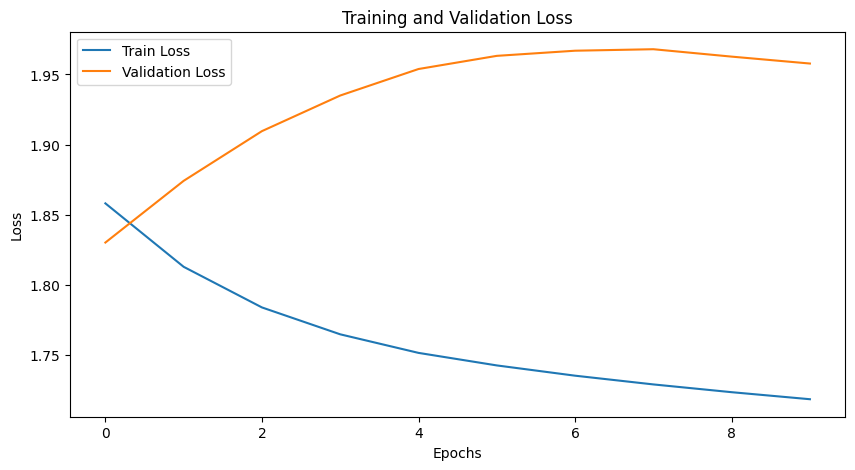

VGGish Test Accuracy: 4.45%


In [51]:
# train, validate, test model
model_VGGish = MyVGGish(num_classes=len(label_encoder.classes_)).to("cuda" if torch.cuda.is_available() else "cpu")
train_losses, val_losses, val_accuracies = train_and_validate(model_VGGish, train_loader, val_loader, class_weights_tensor, num_epochs=10)
plot_loss_curve(train_losses, val_losses)
test_accuracy = test_model_accuracy(model_VGGish, test_loader)
print(f'VGGish Test Accuracy: {test_accuracy:.2f}%') # round to 2 decimals

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions and true labels for confusion matrix
all_preds = []
all_labels = []

model_VGGish.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model_VGGish(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

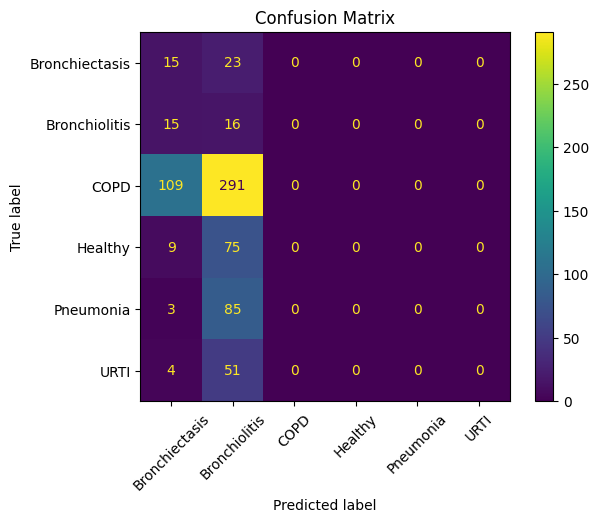

In [53]:
# Visualize confusion matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()